<a href="https://colab.research.google.com/github/Marcehlin/Trabalho-ProgEstat/blob/main/Trabalho_Prog_Estat_Tema_Galton_Grupo_Lara_e_Marcelo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introdução

Link do github:
https://github.com/Marcehlin/Trabalho-ProgEstat

Este trabalho tem como objetivo simular o problema da extinção dos sobrenomes formulado por Galton-Watson, analisando-o por meio de diferentes distribuições de probabilidade, sendo elas a Binomial, Poisson, Uniforme Discreta, e algumas distribuições discretas. Utilizando de experimentos computacionais, este estudo procura analisar a sobrevivência de linhagens ao decorrer do tempo, para, por fim, resolver algumas questões centrais do problema:
1. Sob quais condições um sobrenome está destinado a desaparecer?
2. Como a distribuição do número de descendentes afeta a probabilidade de extinção?
3. Qual é a distribuição do tempo até extinção nos diferentes regimes?

# Descrição do modelo

Processo de Galton-Watson:
1. $Z_0 = 1$ (ancestral inicial)
2. Para cada geração k, enquanto $Z_k > 0$ e $Z_k < 10^6$:
* $Z_{k+1}$ = $\sum_{j=1}^{Z_k} X_j$, onde $X_j ∼ D$ é a distribuição da prole, e $X_j$ são i.i.d.
* $D ∼ Poisson(λ)$ ou $Binomial(n, p)$ ou uma distribuição discreta
* k = k + 1
3. Se $Z_k = 0$, a linhagem se extinguiu na geração k. Registre o tempo de extinção. Se $Z_k > 10^6$ consideramos que a trajetória não extinta e truncada.
A probabilidade de extinção é estimada pela frequência de trajetórias que se extinguiram em um grande número de simulações.

# Metodologia

Para a análise deste problema, utilizamos de duas funções principais. A primeira função irá simular o processo de ramificação e retornar uma lista, ao passo que a segunda irá repetir esse processo M vezes e retornar um dataframe com as informações necessárias para a formulação de uma conclusão.

**Função principal do processo de ramificação**

Simula um único processo de ramificação e retorna uma lista:

In [ ]:
processo_de_ramificacao <- function(dist, p1, p2, G_0 = 1,fp = NULL){
  #Abaixo é uma variável que armazena os dados que estamos interessados em um processo de ramificação
  #Extinção é booleana, 0 se o processo não extinto, 1 caso contrário
  #Tempo de Extinção: um número inteiro que armazena o tempo de extinção do processo
  #Total do Processo: um número inteiro que armazena o total de descendentes do processo
  #História: um vetor numerico que armazena a quantidade de filhos de cada geração, ou seja, os Z_i's
  resultado_processo <- list(Extincao = FALSE, Tempo_Extincao = NA, Total_do_Processo = 1, Historia = numeric())

  resultado_processo$Historia[1] <- G_0 # A familia começa com um ancestral
  k <- 1 #Indice para iterar o processo

  #Em vez de verificar o total, agora se verifica se a última geração ultrapassa 1e6
  while (resultado_processo$Historia[k] > 0 && resultado_processo$Historia[k] < 1000000){
    if (dist == "poisson"){
      incremento <- rpois(resultado_processo$Historia[k], p1)
    }

    else if (dist == "binomial"){
      incremento <- rbinom(resultado_processo$Historia[k], size = p1, prob = p2)
    }
    else if (dist == "personalizada"){
      incremento <- sum(sample(size = resultado_processo$Historia[k],
                            x = fp$suporte,
                            p = fp$probabilidade,
                            replace = TRUE))
    }
    else
    {
      return(-1)
    }

    resultado_processo$Historia[k+1] <- sum(incremento)
    resultado_processo$Total_do_Processo <- resultado_processo$Total_do_Processo + resultado_processo$Historia[k+1]
    k <- k + 1
  }

  if (resultado_processo$Historia[k] == 0){
    resultado_processo$Extincao <- TRUE
    resultado_processo$Tempo_Extincao <- k - 1
  }

return (resultado_processo) #Retornar a lista que tem os dados necessários para análise
}

**Função para múltiplas simulações**

Repete M vezes a função acima, e pega as listas retornadas para junta em um dataframe + uma lista das histórias para montar a trajetória depois

In [ ]:
simular <- function(dist, p1, p2, G0, M, fp = NULL) {
    #Criar uma lista vazia para colocar resultado de cada simulação
    resultados <- list()

    for (i in 1:M){
      resultados[[i]] <- processo_de_ramificacao(dist, p1, p2, G_0 = G0, fp)
    }

    #Extrair apenas as métricas numéricas para o dataframe, porque se colocar a história junto vai ficar pesado
    df <- data.frame(
      Extincao = sapply(resultados, function(x) x$Extincao),
      Tempo_Extincao = sapply(resultados, function(x) x$Tempo_Extincao),
      Total_do_Processo = sapply(resultados, function(x) x$Total_do_Processo)
    )

    #Manter as histórias como lista separada
    historias <- lapply(resultados, function(x) x$Historia)

    #Retornar uma lista de 2 elementos, primeiro é o dataframe das métricas, segundo é o vetor das histórias
    return (list(df = df,historias = historias))
}

# Experimentos

Para a realização dos experimentos, iremos classificar diferentes distribuições seguindo o seguinte critério:

* Subcrítico (Média< 1): A extinção é garantida.

* Crítico (Média = 1): A extinção também é garantida, mas o processo pode demorar mais.

* Supercrítico (Média > 1): Há uma probabilidade positiva de sobrevivência eterna.

Além disso, para a simulação, serão utlizados os seguintes distribuição:

1. $Poisson(0.8)$
   - Média = 0.8
   - Regime: Subcrítico

2. $Poisson(1.0)$
   - Média = 1.0  
   - Regime: Crítico

3. $Poisson(1.2)$
   - Média = 1.2
   - Regime: Supercritico

4. $Poisson(2.0)$
   - Média = 2.0
   - Regime: Supercrítico

5. $Binomial(2, 0.3)$
   - Média = 0.6
   - Regime: Subcrítico

6. $Binomial(2, 0.5)$
   - Média = 1.0
   - Regime: Crítico

7. $Binomial(2, 0.6)$
   - Média = 1.2
   - Regime: Supercrítico

8. $Binomial(4, 0.5)$
   - Média = 2.0
   - Regime: Supercrítico

9. $Uniforme$ $Discreta$ {$0,2$}
   - Média = 1.0
   - Regime: Crítico

10. $P(X=0) = 0.3, P(X=1) = 0.2, P(X=2) = 0.3, P(X=3) = 0.2$
    - Média= 1.2
    - Regime: Supercrítico

11. $P(X=0) = 0.5, P(X=2) = 0.49, P(X=100) = 0.01$
    - Média = 1.98
    - Regime: Supercrítico



Teoricamente, o cálculo da probabilidade de extinção (e) da distribuição que possui média igual à $\mu$ e com função geradora de probabilidades $g(s)$, segue o seguinte modelo:
$$
e = \left\{
\begin{array}{ll}
1 & \text{para } \mu \leq 1 \\
s_0 & \text{para } \mu > 1
\end{array}
\right.
$$

Onde $s_0$ é a menor raiz positiva de $g(s) = s$ no intervalo $(0,1)$

Porém, para as distribuições que serão utlizadas, o cálculo da raíz da f.g.p. delas é de difícil obtenção analítica, portanto utilizamos de simulações computacionais do processo de Galton-Watson a fim de aproximar esse valor.

In [ ]:
#Configurações dos experimentos
set.seed(114514)
M <- 10000

#Uma lista de regime, para cada regime faremos M simulações
regimes <- list(
  subcritico_poisson = list(dist = "poisson", p1 = 0.8, p2 = NULL), #Média = 0.8
  critico_poisson = list(dist = "poisson", p1 = 1.0, p2 = NULL), #Média = 1.0
  supercritico_1_2_poisson = list(dist = "poisson", p1 = 1.2, p2 = NULL), #Média = 1.2
  supercritico_2_0_poisson = list(dist = "poisson", p1 = 2.0, p2 = NULL), #Média = 2.0

  subcritico_binom = list(dist = "binomial", p1 = 2, p2 = 0.3), #Média = 0.6
  critico_binom = list(dist = "binomial", p1 = 2, p2 = 0.5), #Média = 1.0
  supercritico_1_2_binom = list(dist = "binomial", p1 = 2, p2 = 0.6), #Média = 1.2
  supercritico_2_0_binom = list(dist = "binomial", p1 = 4, p2 = 0.5), #Média = 2.0

  dist_personalizada_1 = list(dist = "personalizada",p1 = NULL, p2 = NULL, G_0 = 1, fp = list(suporte = 0:2, probabilidade = c(0.5, 0, 0.5))), #Média = 1.0
  dist_personalizada_2 = list(dist = "personalizada",p1 = NULL, p2 = NULL, G_0 = 1, fp = list(suporte = 0:3, probabilidade = c(0.3, 0.2, 0.3, 0.2))), #Média = 1.2
  dist_personalizada_3 = list(dist = "personalizada",p1 = NULL, p2 = NULL, G_0 = 1, fp = list(suporte = c(0, 2, 100), probabilidade = c(0.5, 0.49, 0.01))) #Média = 1.98
)

resultados_simulacoes <- list()

for (nome in names(regimes)) {
  cat("Simulando:", nome, "\n")
  config <- regimes[[nome]]
  resultados_simulacoes[[nome]] <- simular(dist = config$dist, p1 = config$p1, p2 = config$p2, G0 = 1, M = M, fp = config$fp)
}

Simulando: subcritico_poisson 
Simulando: critico_poisson 
Simulando: supercritico_1_2_poisson 
Simulando: supercritico_2_0_poisson 
Simulando: subcritico_binom 
Simulando: critico_binom 
Simulando: supercritico_1_2_binom 
Simulando: supercritico_2_0_binom 
Simulando: dist_personalizada_1 
Simulando: dist_personalizada_2 
Simulando: dist_personalizada_3 


# Resultados

Código para gerar gráfico úteis para a visualização do resultado:

In [ ]:
install.packages("ggpmisc")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘gridExtra’, ‘xts’, ‘zoo’, ‘SparseM’, ‘MatrixModels’, ‘mvtnorm’, ‘TH.data’, ‘sandwich’, ‘bitops’, ‘ggpp’, ‘confintr’, ‘polynom’, ‘quantreg’, ‘lmodel2’, ‘splus2R’, ‘multcomp’, ‘multcompView’, ‘plyr’, ‘caTools’




In [ ]:
library(dplyr)
library(ggplot2)
library(purrr)

freq <- sapply(resultados_simulacoes, function(x) sum(x$df$Extincao))

#Probabilidade de extinção será a média da variável binária que indica se o processo se extingiu ou não (Extinção)
prob_extincao <- sapply(resultados_simulacoes, function(x) mean(x$df$Extincao))

#Calcular o tempo médio de extinção para cada regime que fizemos simulação
tempo_medio_extincao <- sapply(resultados_simulacoes, function(x) {
  tempos <- x$df$Tempo_Extincao
  tempos <- tempos[is.finite(tempos)]
  return (mean(tempos))
})

tempo_max_extincao <- sapply(resultados_simulacoes, function(x) {
  tempos <- x$df$Tempo_Extincao
  tempos <- tempos[is.finite(tempos)]
  return (max(tempos))
})

mediana_tempo_extincao <- sapply(resultados_simulacoes, function(x) {
  tempos <- x$df$Tempo_Extincao
  tempos <- tempos[is.finite(tempos)]
  return (median(tempos))
})

#Metricas em um dataframe, para fazer plot_01 e plot02
metricas <- data.frame(
  Regimes = names(regimes),
  Frequencia_absoluta = freq,
  Prob_Extincao = prob_extincao,
  Tempo_Medio_Extincao = tempo_medio_extincao,
  Tempo_max_Extincao = tempo_max_extincao,
  Mediana_Tempo_Extincao = mediana_tempo_extincao
)

#Tempos em uma dataframe, para fazer plot_03
dados_tempos <- data.frame()
for (nome in names(resultados_simulacoes)) {
  tempos <- resultados_simulacoes[[nome]]$df$Tempo_Extincao
  # Filtrar apenas os tempos finitos (onde houve extinção)
  tempos_finite <- tempos[is.finite(tempos)]
  if (length(tempos_finite) > 0) {
    dados_tempos <- rbind(dados_tempos,
                         data.frame(Regime = nome, Tempo_Extincao = tempos_finite))
  }
}


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




Warning message in geom_table(data = metricas, aes(x = 0, y = 0, label = list(metricas)), :
“All aesthetics have length 1, but the data has 11 rows.
ℹ Please consider using `annotate()` or provide this layer with data containing
  a single row.”


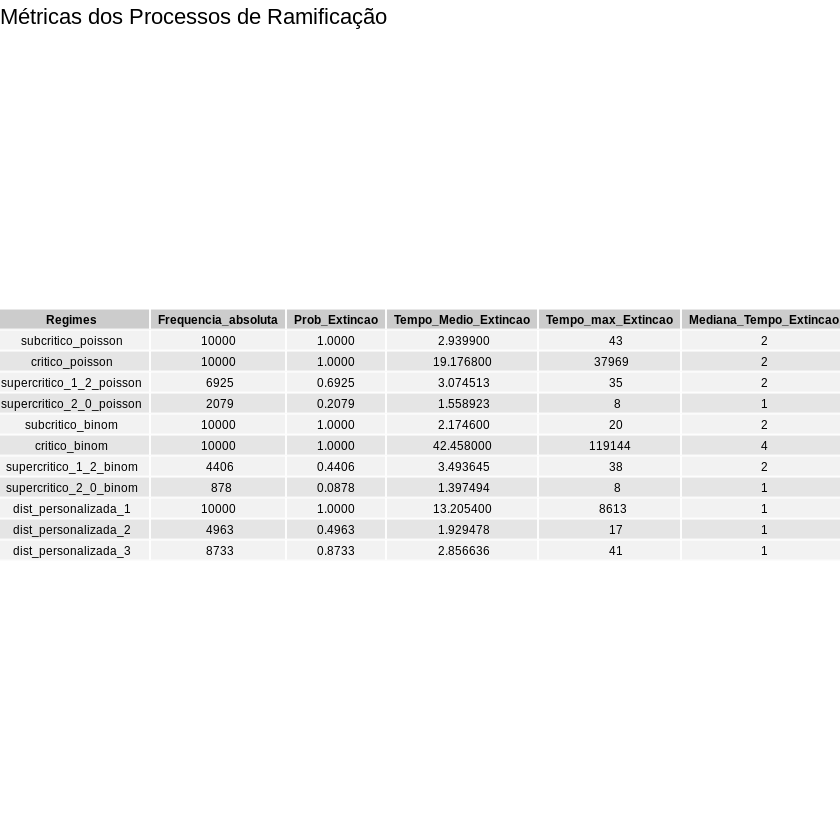

In [ ]:
#library(ggpmisc)

#tabela_dados_de_interesse <- ggplot() +
  #geom_table(
    #data = metricas,
    #aes(x = 0, y = 0, label = list(metricas)),
    #size = 4
  #) +
  #theme_void() +
  #ggtitle("Métricas dos Processos de Ramificação")
#tabela_dados_de_interesse


library(ggpmisc)

tabela_dados_de_interesse <- ggplot() +
  geom_table(
    data = metricas,
    aes(x = 0, y = 0, label = list(metricas)),
    size = 2.5
  ) +
  theme_void() +
  ggtitle("Métricas dos Processos de Ramificação") +
  coord_cartesian(xlim = c(-1, 1), ylim = c(-1, 1))
tabela_dados_de_interesse
#peguei isso do gpt, mas ainda ss continua cortado, ta menos cortado mas ta meio apertado
#minha ideia eh tirar o dado mediana, mas ai vc qm sabe marcelao

**Gráfico 1: Mostra as frequências relativas, ou seja, as probabilidades de extinção por regime estabelecido**

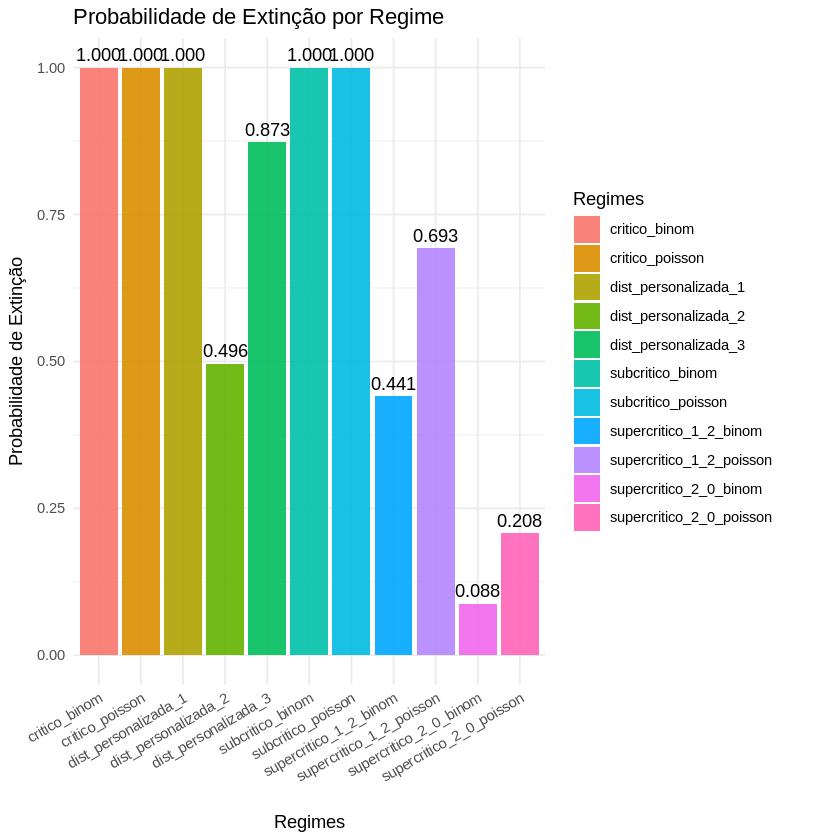

In [ ]:
plot_01 <- ggplot(metricas, aes(x = Regimes, y = Prob_Extincao, fill = Regimes)) +
  geom_col(alpha = 0.9) + #Transparência das barras
  geom_text(aes(label = sprintf("%.3f", Prob_Extincao)), vjust = -0.5) +
  labs(title = "Probabilidade de Extinção por Regime",
       x = "Regimes",
       y = "Probabilidade de Extinção") +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 30, hjust = 1))
plot_01

**Gráfico 2: Mostra as médias de tempo de extinção por regime estabelecido, considerando apenas processos**

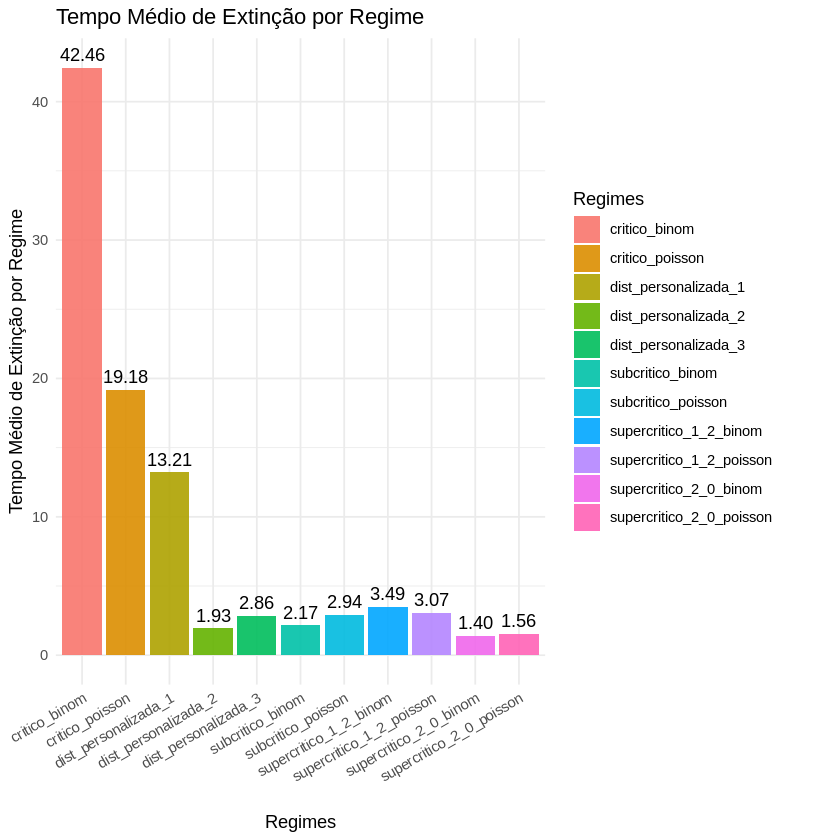

In [ ]:
plot_02 <- ggplot(metricas, aes(x = Regimes, y = tempo_medio_extincao, fill = Regimes)) +
  geom_col(alpha = 0.9) +
  geom_text(aes(label = sprintf("%.2f", tempo_medio_extincao)), vjust = -0.5) +
  labs(title = "Tempo Médio de Extinção por Regime",
       x = "Regimes",
       y = "Tempo Médio de Extinção por Regime") +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 30, hjust = 1))
plot_02

**Gráfico 3: Mostra a distribuição do tempo de extinção para cada regime (apenas para as simulações que se extinguiram)**

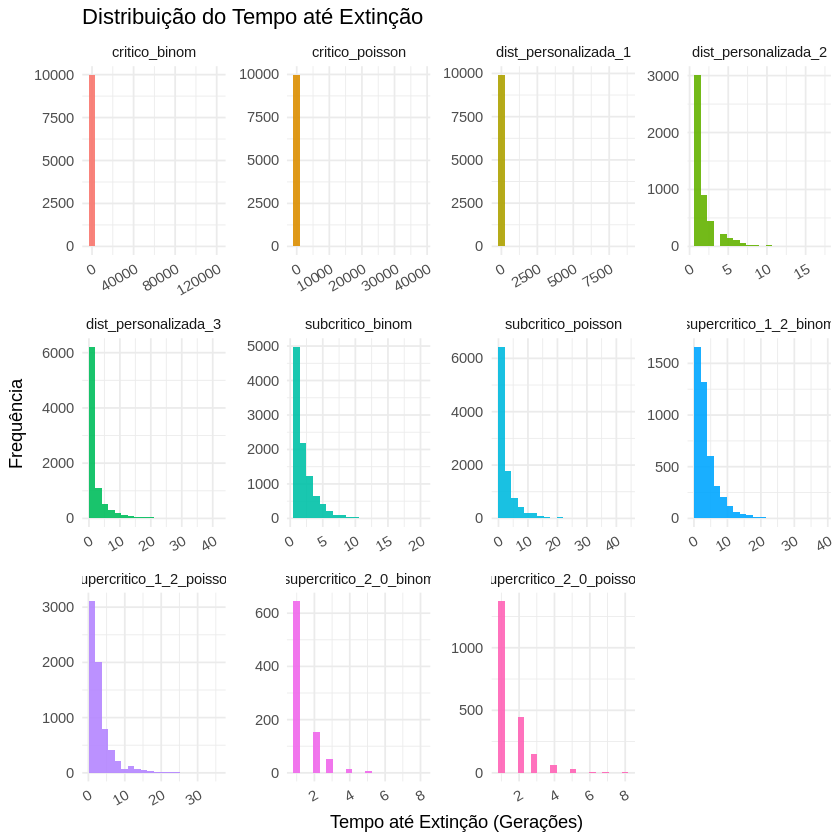

In [ ]:
plot_03 <- ggplot(dados_tempos, aes(x = Tempo_Extincao, fill = Regime)) +
  geom_histogram(alpha = 0.9, bins = 20) +
  facet_wrap(~Regime, scales = "free") +
  labs(title = "Distribuição do Tempo até Extinção",
       x = "Tempo até Extinção (Gerações)",
       y = "Frequência") +
  theme_minimal() +
  theme(legend.position = "none",
        axis.text.x = element_text(angle = 30, hjust = 1))
plot_03

**Gráficos 4: As trajetórias dos processos**

In [ ]:
library(data.table)

#Criar uma lista de gráficos das trajetórias dos processos
trajetorias <- list()

for (nome in names(regimes)) {
  historias <- resultados_simulacoes[[nome]]$historias
  n_trajetorias <- min(1000, length(historias))
  max_tamanho <- max(sapply(historias[1:n_trajetorias], length))

  #Converter a lista para data.table no formato adequado
  data <- rbindlist(

    lapply(1:n_trajetorias, function(i) {
      trajetoria <- historias[[i]]

  #Se o processo extinguiu, estender a trajetória com zeros até max_length
  if (resultados_simulacoes[[nome]]$df$Extincao[i]) {
    trajetoria_completa <- c(trajetoria, rep(0, max_tamanho - length(trajetoria)))
  }

  #Se não extinguiu, preencher com NA
  else {
    trajetoria_completa <- c(trajetoria, rep(NA, max_tamanho - length(trajetoria)))
  }

  data.table(
    t = 1:max_tamanho,
    value = trajetoria_completa,
    variable = paste0("sim", i)
      )
    })

  )

  #Criar os gráficos (usando código desse blog: https://bookdown.org/probability/bookdown-demo/branching-processes.html)
  trajetorias[[nome]] <- ggplot(data, aes(x = t, y = value, col = variable)) +
    geom_line(alpha = 0.6) +
    theme_bw() +
    theme(legend.position = "none") +
    ggtitle(paste("Processo de Ramificação - ", nome)) +
    xlab("Tempo") +
    ylab("Tamanho da população no tempo i (Z_i)")
}


Attaching package: ‘data.table’


The following object is masked from ‘package:purrr’:

    transpose


The following objects are masked from ‘package:dplyr’:

    between, first, last




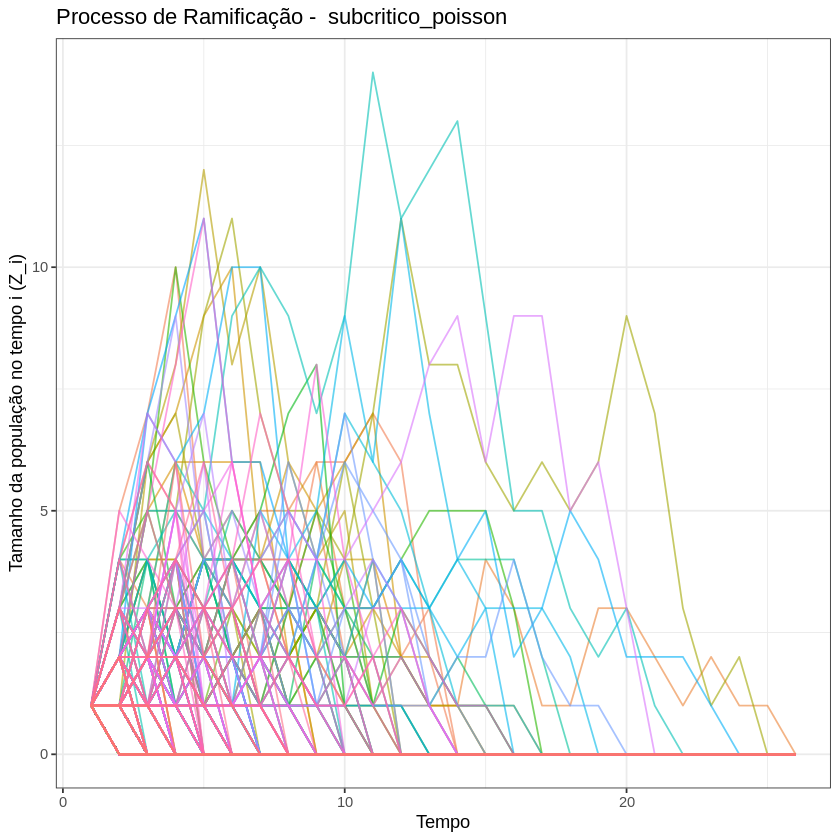

In [ ]:
print(trajetorias[["subcritico_poisson"]])

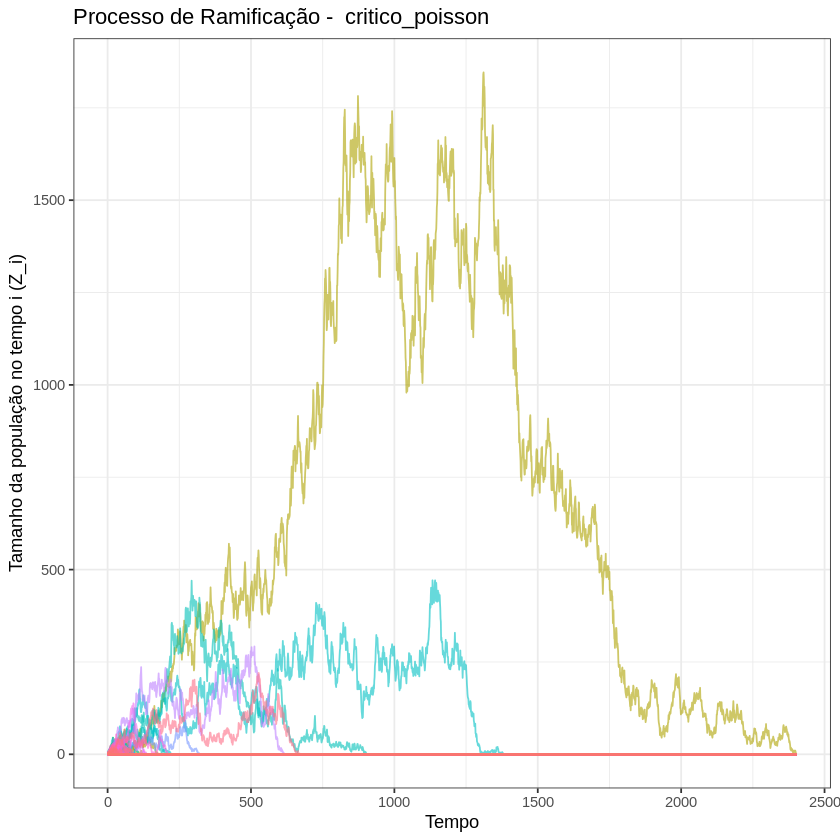

In [ ]:
print(trajetorias[["critico_poisson"]])

Warning message:
“Removed 10407 rows containing missing values or values outside the scale range
(`geom_line()`).”


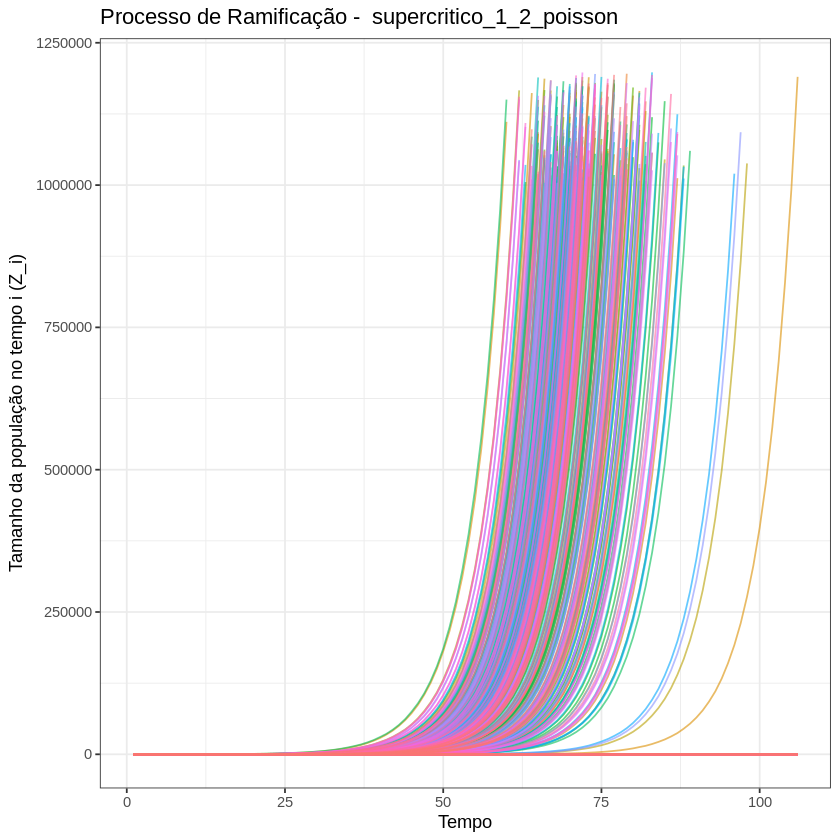

In [ ]:
print(trajetorias[["supercritico_1_2_poisson"]])

Warning message:
“Removed 6570 rows containing missing values or values outside the scale range
(`geom_line()`).”


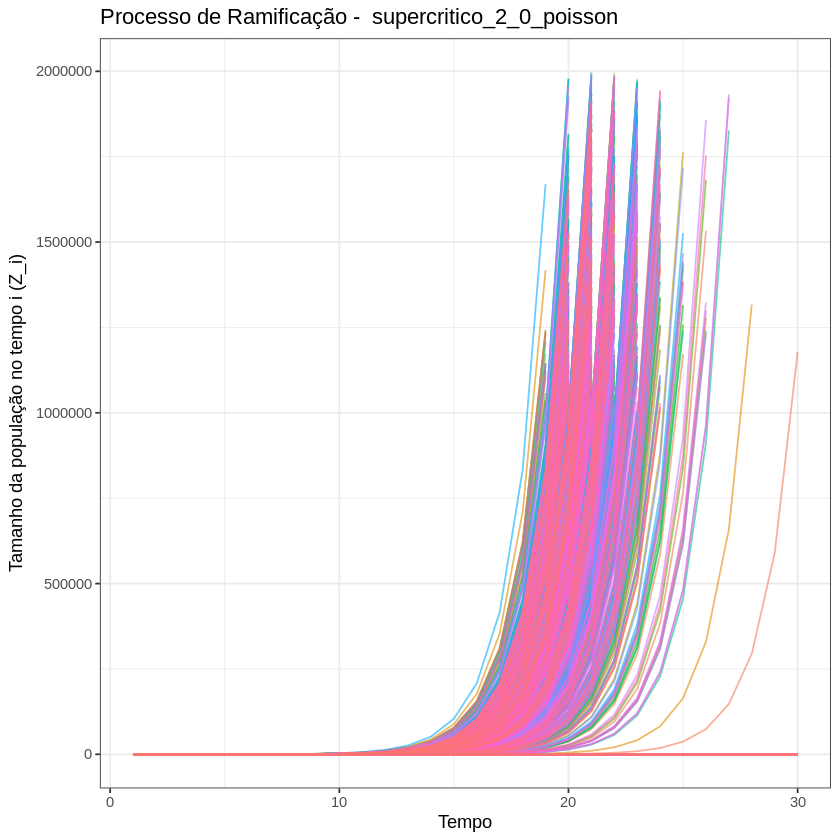

In [ ]:
print(trajetorias[["supercritico_2_0_poisson"]])

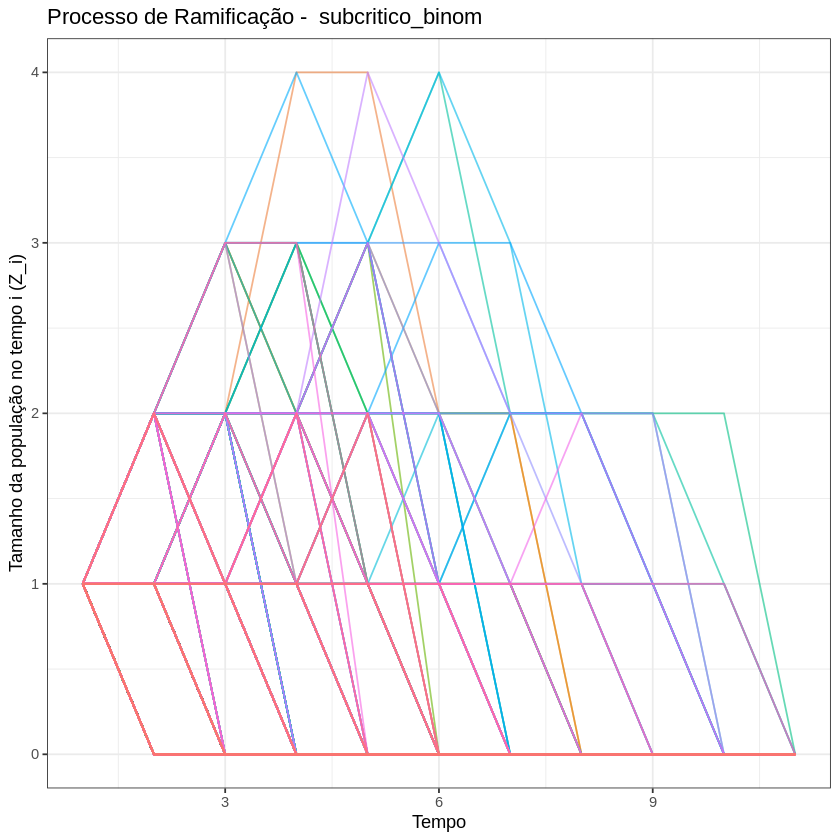

In [ ]:
print(trajetorias[["subcritico_binom"]])

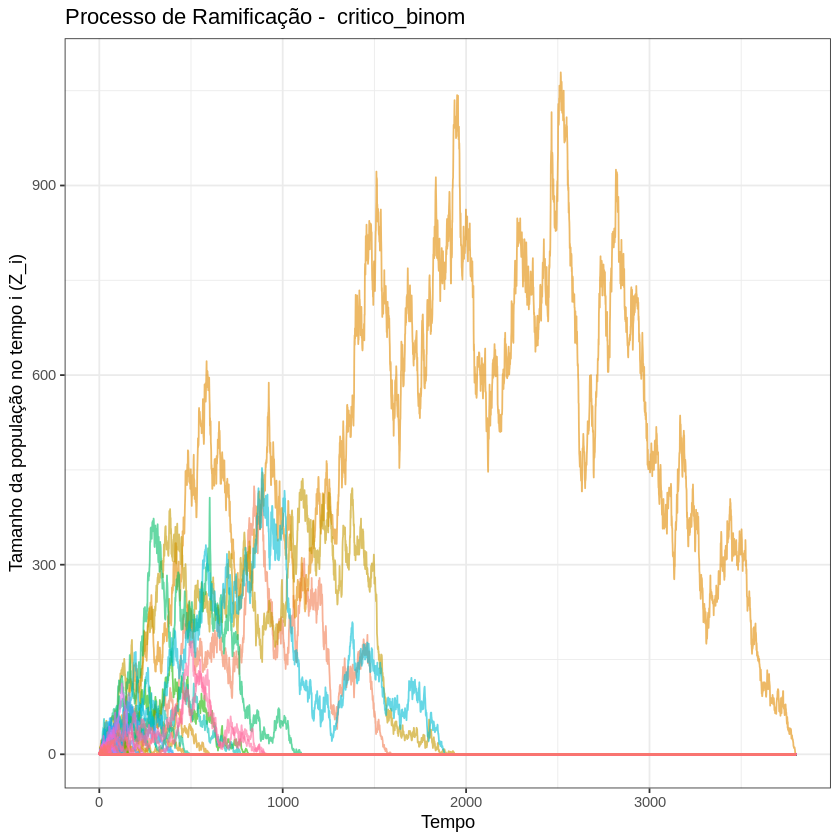

In [ ]:
print(trajetorias[["critico_binom"]])

Warning message:
“Removed 13961 rows containing missing values or values outside the scale range
(`geom_line()`).”


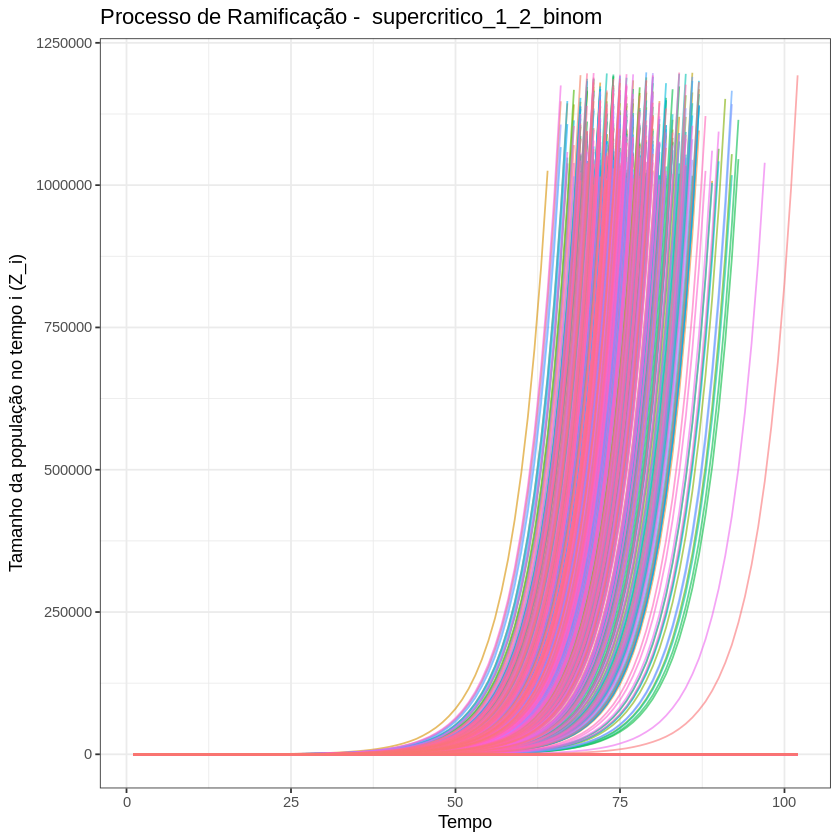

In [ ]:
print(trajetorias[["supercritico_1_2_binom"]])

Warning message:
“Removed 3986 rows containing missing values or values outside the scale range
(`geom_line()`).”


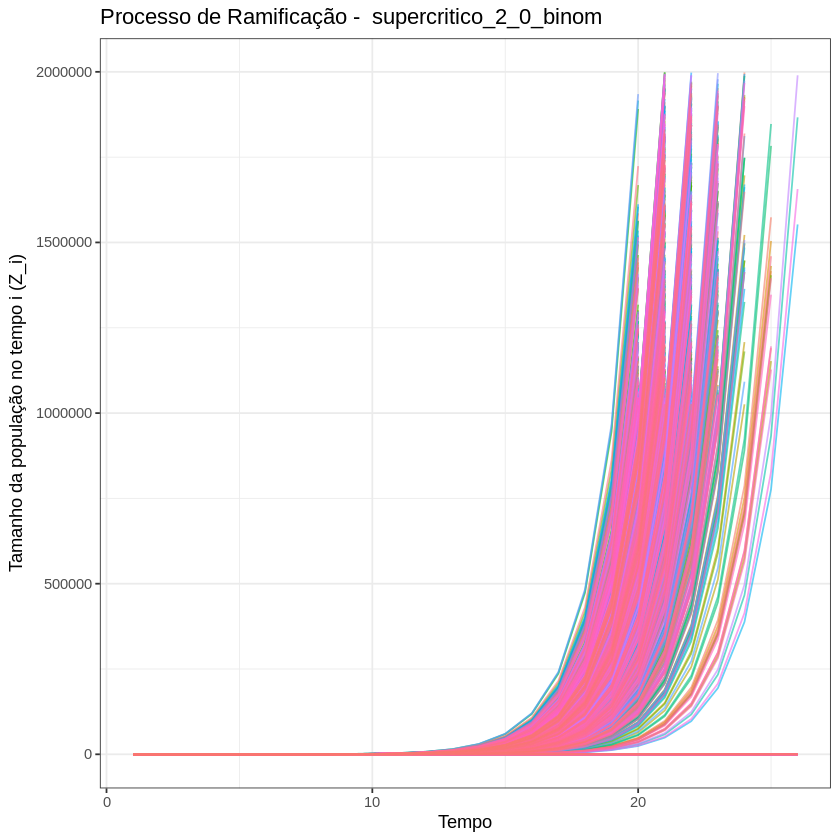

In [ ]:
print(trajetorias[["supercritico_2_0_binom"]])

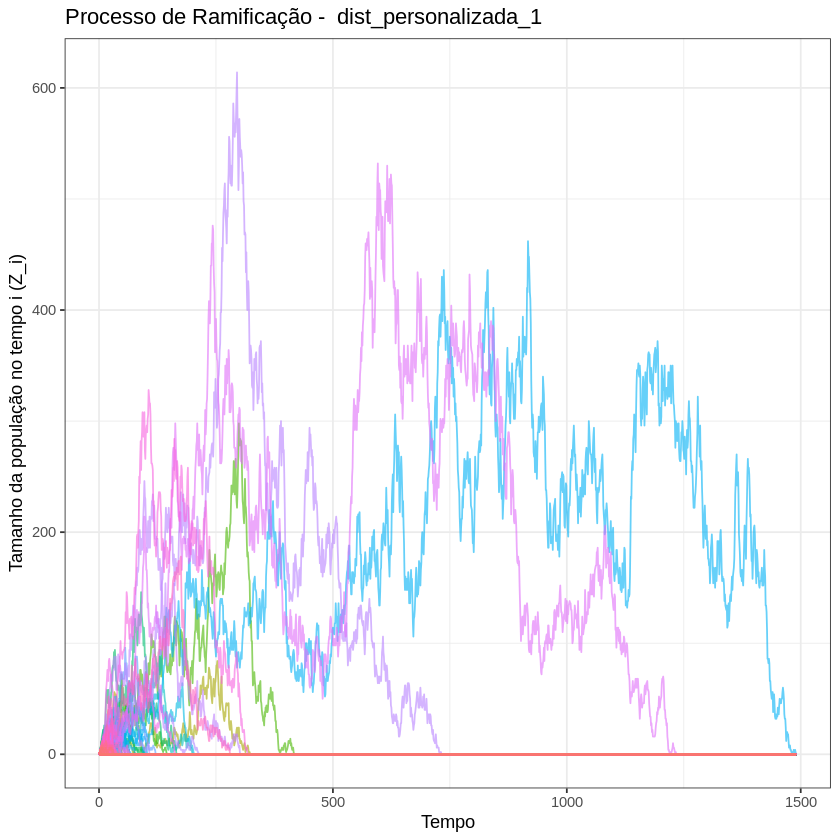

In [ ]:
print(trajetorias[["dist_personalizada_1"]])

Warning message:
“Removed 5648 rows containing missing values or values outside the scale range
(`geom_line()`).”


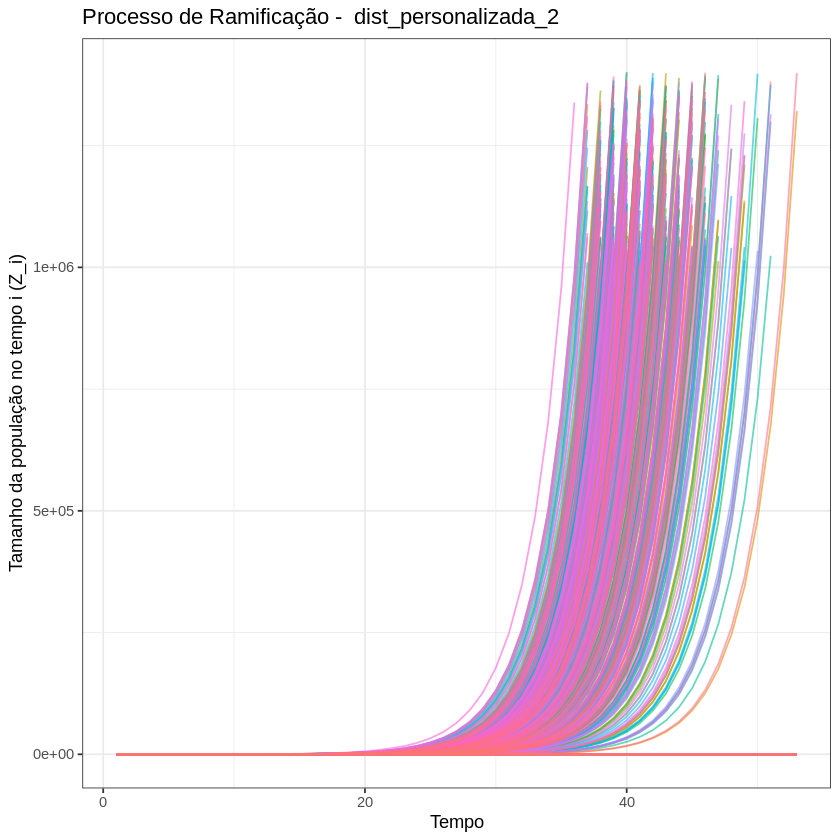

In [ ]:
print(trajetorias[["dist_personalizada_2"]])

Warning message:
“Removed 2325 rows containing missing values or values outside the scale range
(`geom_line()`).”


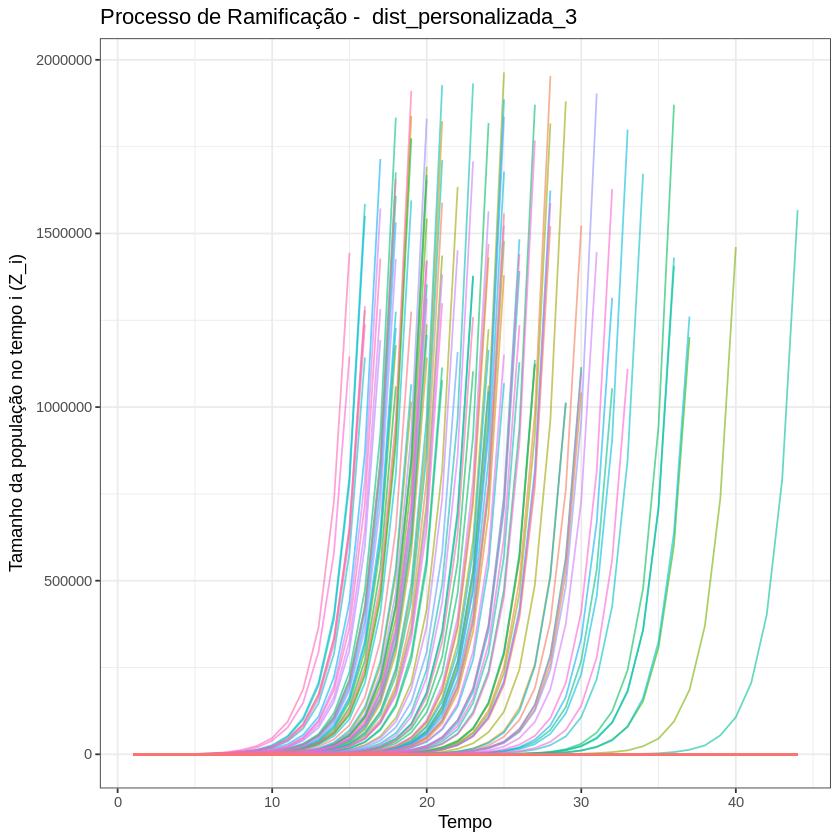

In [ ]:
print(trajetorias[["dist_personalizada_3"]])

#Conclusão

A partir dos experimentos e gráficos gerados, podemos concluir que processos de ramificação com distribuições cuja média é maior que 1 possuem probabilidade positiva de sobrevivência eterna. De forma análoga, processos cuja distribuição possui média menor ou igual à 1 irão se extinguir em algum momento.
Além disso, o tempo de extinção possui, em sua maioria, uma distribuição aproximadamente exponencial.